In [1]:
import matplotlib.pyplot as plt
import dtaidistance
import numpy as np
from scipy.spatial.distance import euclidean

Генерация сигнала

1 тип - полуовалы

2 тип - синусы

3 тип - нормальное распределение

7 сигналов каждого типа

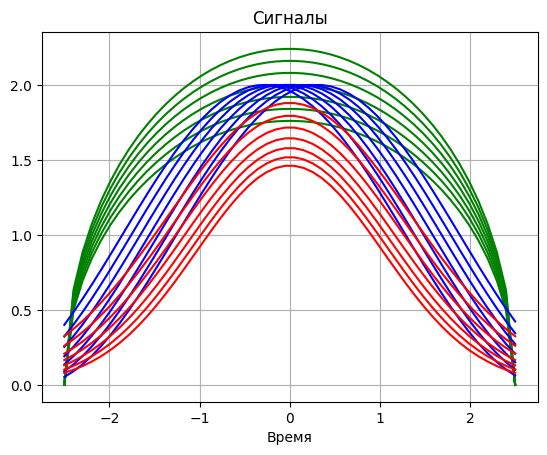

In [2]:
# индекс и отсчет времени в секундах
time_index = np.linspace(-5, 5, 50) * 0.5

tseries_list = {'Time': time_index}

for i in range(7):
    tseries_list["circle"+str(i + 1)] = np.sqrt(6.25 - time_index ** 2) * (1 + (i - 3) / 25) * 0.8

for i in range(7):
    tseries_list["sine"+str(i + 1)] = np.sin(time_index + np.pi / 2 + (-np.pi + i) / 10) + 1

for i in range(7):
    tseries_list["normdist" + str(i + 1)] = np.exp(-time_index ** 2 / (2 * (28 / (21 + i)) ** 2)) * 1.41 * (28 / (21 + i))


# отрисовка всех сигналов
for i in range(7):
    plt.plot(time_index, tseries_list["circle"+str(i + 1)], '-g')

for i in range(7):
    plt.plot(time_index, tseries_list["sine"+str(i + 1)], '-b')

for i in range(7):
    plt.plot(time_index, tseries_list["normdist"+str(i + 1)], '-r')
            
plt.title('Сигналы')
plt.xlabel('Время')
plt.grid()

In [3]:
# Посчитаем среднее попарных расстояний для всех возможных пар классов
dist_list = [[tseries_list["circle"+str(i + 1)] for i in range(7)], [tseries_list["sine"+str(i + 1)] for i in range(7)], [tseries_list["normdist"+str(i + 1)] for i in range(7)]]

print("Euclidean distances:")
print("-----------------------------------------------------")
print("|            |   circle   |    sine    |  normdist  |")
print("|------------|------------|------------|------------|")
for i in range(3):
    print("|" + ["circle", "sine", "normdist"][i].center(12, " ") + "|", sep="", end="")
    for j in range(3):
        ti = 0.0
        for p1 in range(7):
            for p2 in range(7):
                ti += euclidean(dist_list[i][p1], dist_list[j][p2])
        ti /= 49.0
        print(str(int(ti * 10000) / 10000)[:6].center(12, " ") + "|", sep="", end="")
    print()
    print(["|------------|------------|------------|------------|", "-----------------------------------------------------"][i == 2])
print()

print("DTW:")
print("-----------------------------------------------------")
print("|            |   circle   |    sine    |  normdist  |")
print("|------------|------------|------------|------------|")
for i in range(3):
    print("|" + ["circle", "sine", "normdist"][i].center(12, " ") + "|", sep="", end="")
    for j in range(3):
        ti = 0.0
        for p1 in range(7):
            for p2 in range(7):
                ti += dtaidistance.dtw.distance(dist_list[i][p1], dist_list[j][p2])
        ti /= 49.0
        print(str(int(ti * 10000) / 10000)[:6].center(12, " ") + "|", sep="", end="")
    print()
    print(["|------------|------------|------------|------------|", "-----------------------------------------------------"][i == 2])

Euclidean distances:
-----------------------------------------------------
|            |   circle   |    sine    |  normdist  |
|------------|------------|------------|------------|
|   circle   |   1.0448   |   3.0721   |   4.6468   |
|------------|------------|------------|------------|
|    sine    |   3.0721   |   1.2326   |   2.4522   |
|------------|------------|------------|------------|
|  normdist  |   4.6468   |   2.4522   |   1.1665   |
-----------------------------------------------------

DTW:
-----------------------------------------------------
|            |   circle   |    sine    |  normdist  |
|------------|------------|------------|------------|
|   circle   |   0.6842   |   0.7948   |    1.68    |
|------------|------------|------------|------------|
|    sine    |   0.7948   |   0.2614   |   1.1277   |
|------------|------------|------------|------------|
|  normdist  |    1.68    |   1.1277   |   0.4716   |
-----------------------------------------------------


#### Эвклидовы расстояния лучше чувствуют разницу между полукругами и всем остальным; DTW лучше чувствуют разницу между синусом и всем остальным; разницу между нормальным распределением и всем остальным чувствуют примерно одинаково

In [4]:
x = []
Y = []

for v in tseries_list:
    if v != 'Time':
        x.append(tseries_list[v])
        Y.append({"circle": 0, "sine": 1, "normdist": 2}[v[:-1]])

arr = np.arange(len(Y))
np.random.shuffle(arr)

print(arr)
print("Классы принадлежности сигналов в тесте:")
print(*(lambda x: [t // 7 for t in x])(arr[-6:]))

X_train = []
X_test = []
y_train = []
y_test = []

for i in arr[:-6]:
    X_train.append(x[i])
    y_train.append(Y[i])

for i in arr[len(X_train):]:
    X_test.append(x[i])
    y_test.append(Y[i])


[ 4  8  0  6 10 19 12  9 18 11 14  2  3 17 16 13  7 15  1  5 20]
Классы принадлежности сигналов в тесте:
1 1 2 0 0 2


In [5]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print()
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0

Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2



In [6]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print()
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0

Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2



In [7]:
from pyts.classification import TimeSeriesForest
 
clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print()
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0

Вектор вероятности принадлежности к классам [[0.09  0.546 0.364]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.214 0.574 0.212]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.016 0.104 0.88 ]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0.922 0.03  0.048]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.978 0.02  0.002]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.012 0.01  0.978]]
Истинный класс для предсказаний 2



### Вывод: все модели выдали верный результат
